In [84]:
import math
from dataclasses import dataclass
from typing import Tuple, Callable
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from itertools import product
import random
import time
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import defaultdict

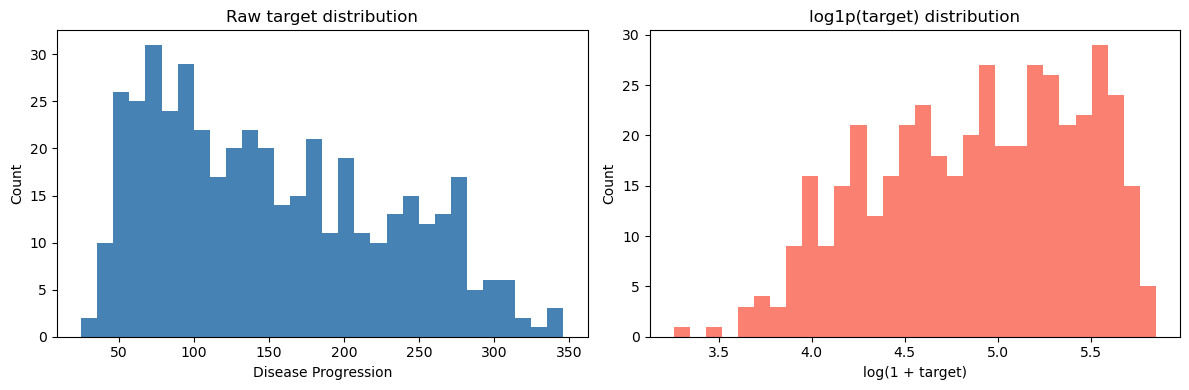

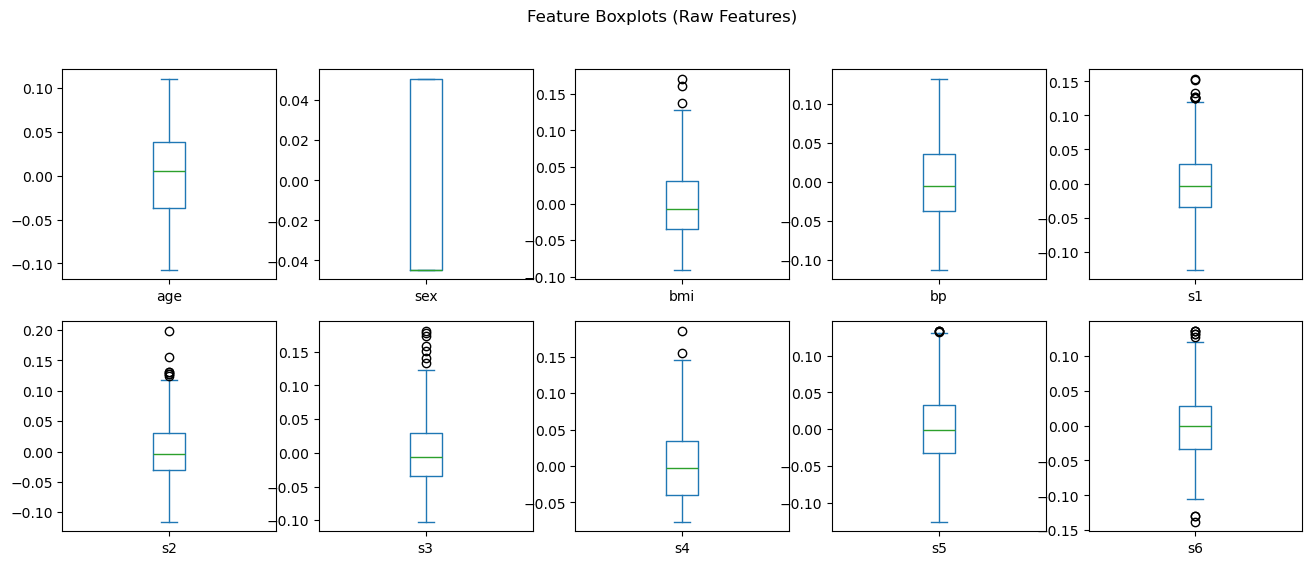

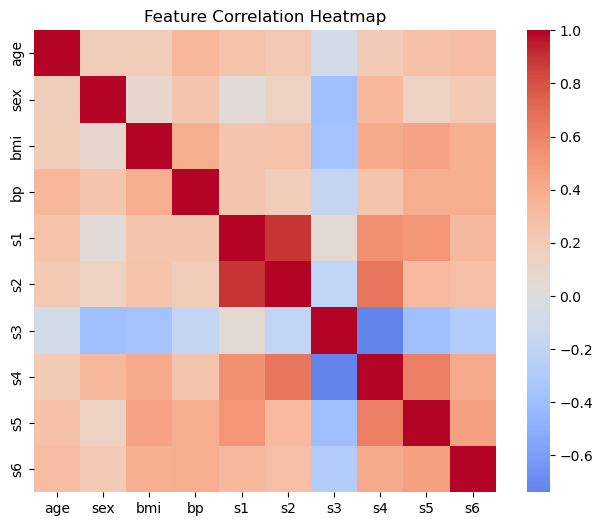

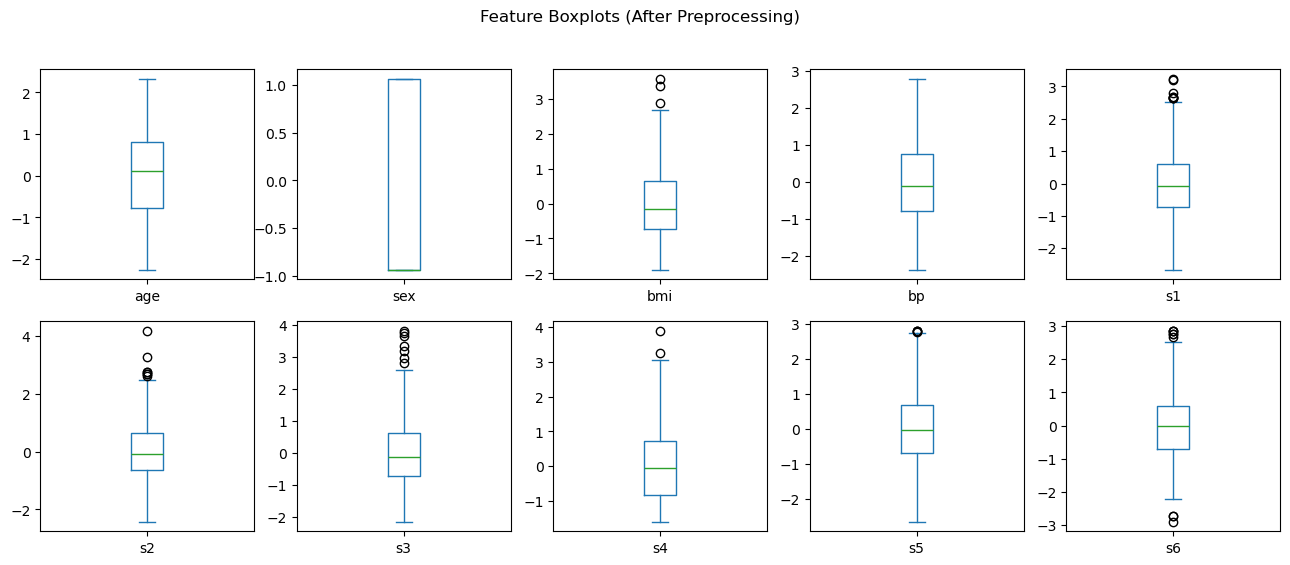

(442, 10) (442,)


In [85]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

diabetes = load_diabetes()
X = diabetes.data      
y = diabetes.target    

X_df = pd.DataFrame(X, columns=diabetes.feature_names)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y, bins=30, color="steelblue")
axes[0].set_title("Raw target distribution")
axes[0].set_xlabel("Disease Progression")
axes[0].set_ylabel("Count")
axes[1].hist(np.log1p(y), bins=30, color="salmon")
axes[1].set_title("log1p(target) distribution")
axes[1].set_xlabel("log(1 + target)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

X_df.plot(kind="box", subplots=True, layout=(2,5), figsize=(16,6), sharey=False)
plt.suptitle("Feature Boxplots (Raw Features)")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(X_df.corr(), cmap="coolwarm", center=0, square=True, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=diabetes.feature_names)

X_scaled_df.plot(kind="box", subplots=True, layout=(2,5), figsize=(16,6), sharey=False)
plt.suptitle("Feature Boxplots (After Preprocessing)")
plt.show()

scaler = StandardScaler()
X = scaler.fit_transform(X)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

print(X.shape, y.shape) 

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)

X_val   = torch.tensor(X_val, dtype=torch.float32)

X_test  = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)   
y_val   = torch.tensor(y_val, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

output_dim = 1

In [95]:

baseline_params_sgd = {
    "lr": [1e-2],
    "momentum": [0.9],
    "weight_decay": [0]
}

baseline_params_scg = {
    "sigma": [1e-6],
    "lambd": [1e-4],
    "weight_decay": [0]
}

baseline_params_lf = {
    "lr": [1e-2],      
    "delta": [1e-3],    
    "eps": [1e-6],     
    "weight_decay": [0]
}

hidden_grid_coarse = [2, 4, 8, 16, 32, 64, 128]

best_cfg_stage1_sgd, results_stage1_sgd = grid_search(
    "SGD", make_sgd, baseline_params_sgd, hidden_grid_coarse,
    X_train, y_train, X_val, y_val,
    is_classification=False, seeds=(0,1,2,3,4)
)

best_cfg_stage1_scg, results_stage1_scg = grid_search(
    "SCG", make_scg, baseline_params_scg, hidden_grid_coarse,
    X_train, y_train, X_val, y_val,
    is_classification=False, seeds=(0,1,2,3,4)
)

best_cfg_stage1_lf, results_stage1_lf = grid_search(
    "LeapFrog", make_leapfrog, baseline_params_lf, hidden_grid_coarse,
    X_train, y_train, X_val, y_val,
    is_classification=False, seeds=(0,1,2,3,4)
)

hidden_perf_all = defaultdict(list)

for results in [results_stage1_sgd, results_stage1_scg, results_stage1_lf]:
    for r in results:
        hidden_perf_all[r["hidden"]].append(r["val_metric_mean"]) 
hidden_avg_all = {h: np.mean(scores) for h, scores in hidden_perf_all.items()}
hidden_std_all = {h: np.std(scores) for h, scores in hidden_perf_all.items()}

print("Hidden size mean R²:", hidden_avg_all)
print("Hidden size stds:", hidden_std_all)

best_size = max(hidden_avg_all, key=hidden_avg_all.get) 
threshold = hidden_avg_all[best_size] - hidden_std_all[best_size]

chosen_size = min([h for h, mean in hidden_avg_all.items() if mean >= threshold])
print("Chosen hidden size (1-SE rule):", chosen_size)


chosen_size = 4

In [91]:
lr = [1e-3, 1e-2, 0.05]
momentum = [0.0, 0.9]
weight_decay = [0, 1e-4, 1e-3]
param_grid_sgd = {
    "lr": lr,
    "momentum": momentum,
    "weight_decay": weight_decay
}

param_grid_scg = {
    "sigma": [1e-5, 1e-6, 1e-7],
    "lambd": [1e-6, 1e-5, 1e-4, 1e-3],
    "weight_decay": [0, 1e-4, 1e-3]
}

lr = [1e-3, 1e-2, 1e-1]
delta = [1e-4, 1e-3, 1e-2]
eps = [1e-6, 3e-6, 1e-5]
weight_decay = [0, 1e-4, 1e-3]
param_grid_lf = {
    "lr": lr,
    "delta": delta,
    "eps": eps,
    "weight_decay": weight_decay
}

best_cfg_sgd, results_sgd = grid_search(
    "SGD", make_sgd, param_grid_sgd, [chosen_size],
    X_train, y_train, X_val, y_val,
    is_classification=False, seeds=(0,1,2,3,4)
)

best_cfg_scg, results_scg = grid_search(
    "SCG", make_scg, param_grid_scg, [chosen_size],
    X_train, y_train, X_val, y_val,
    is_classification=False, seeds=(0,1,2,3,4)
)

best_cfg_lf, results_lf = grid_search(
    "LeapFrog", make_leapfrog, param_grid_lf, [chosen_size],
    X_train, y_train, X_val, y_val,
    is_classification=False, seeds=(0,1,2,3,4)
)

print("Best SGD config:", best_cfg_sgd)
print("Best SCG config:", best_cfg_scg)
print("Best LeapFrog config:", best_cfg_lf)


Best SGD config: {'hidden': 4, 'params': {'lr': 0.05, 'momentum': 0.9, 'weight_decay': 0.001}, 'val_loss_mean': 0.6661786249315413, 'val_loss_std': 0.006126609207149406, 'val_metric_mean': 0.6661786249315413, 'val_metric_std': 0.006126609207149406, 'epochs_mean': 489.3222222222222, 'epochs_std': 366.5559477617382, 'time_mean': 8.209972545835708, 'time_std': 6.079449099533029}
Best SCG config: {'hidden': 4, 'params': {'sigma': 1e-06, 'lambd': 0.0001, 'weight_decay': 0}, 'val_loss_mean': 0.6635439173514956, 'val_loss_std': 0.00878400084871422, 'val_metric_mean': 0.6635439173514956, 'val_metric_std': 0.00878400084871422, 'epochs_mean': 109.45263157894736, 'epochs_std': 3.846443117184967, 'time_mean': 2.2944001022138094, 'time_std': 0.5303087263506554}
Best LeapFrog config: {'hidden': 4, 'params': {'lr': 0.1, 'delta': 0.0001, 'eps': 1e-06, 'weight_decay': 0.0001}, 'val_loss_mean': 0.6747733513624636, 'val_loss_std': 0.017980604898038034, 'val_metric_mean': 0.6747733513624636, 'val_metric_s

In [92]:

results_sgd_eval, mses_sgd, maes_sgd, r2s_sgd = evaluate_optimizer("SGD", make_sgd, best_cfg_sgd, chosen_size)
results_scg_eval, mses_scg, maes_scg, r2s_scg = evaluate_optimizer("SCG", make_scg, best_cfg_scg, chosen_size)
results_lf_eval, mses_lf, maes_lf, r2s_lf = evaluate_optimizer("LeapFrog", make_leapfrog, best_cfg_lf, chosen_size)

for res in [results_sgd_eval, results_scg_eval, results_lf_eval]:
    print(f"\n=== {res['optimizer']} Results ===")
    print(f"MSE: {res['mean_rmse']:.3f} ± {res['std_rmse']:.3f}")
    print(f"MAE: {res['mean_mae']:.3f} ± {res['std_mae']:.3f}")
    print(f"R² : {res['mean_r2']:.3f} ± {res['std_r2']:.3f}")
    print(f"Runtime: {res['mean_runtime']:.3f} ± {res['std_runtime']:.3f} sec")
    print(f"Epochs to early-stop: {res['mean_epochs']:.1f} ± {res['std_epochs']:.1f}")


=== SGD Results ===
MSE: 0.697 ± 0.022
MAE: 0.566 ± 0.022
R² : 0.455 ± 0.035
Runtime: 3.466 ± 1.445 sec
Epochs to early-stop: 124.4 ± 50.5

=== SCG Results ===
MSE: 0.713 ± 0.035
MAE: 0.581 ± 0.032
R² : 0.430 ± 0.056
Runtime: 7.924 ± 2.441 sec
Epochs to early-stop: 165.1 ± 50.3

=== LeapFrog Results ===
MSE: 0.794 ± 0.059
MAE: 0.662 ± 0.059
R² : 0.291 ± 0.107
Runtime: 3.308 ± 0.527 sec
Epochs to early-stop: 106.7 ± 8.1


In [93]:

for res in [results_sgd_eval, results_scg_eval, results_lf_eval]:
    print(f"\n=== {res['optimizer']} Results ===")
    print(f"MSE: {res['mean_rmse']:.3f} ± {res['std_rmse']:.3f}")
    print(f"MAE: {res['mean_mae']:.3f} ± {res['std_mae']:.3f}")
    print(f"R² : {res['mean_r2']:.3f} ± {res['std_r2']:.3f}")
    print(f"Runtime: {res['mean_runtime']:.3f} ± {res['std_runtime']:.3f} sec")
    print(f"Epochs to early-stop: {res['mean_epochs']:.1f} ± {res['std_epochs']:.1f}")


=== SGD Results ===
MSE: 0.697 ± 0.022
MAE: 0.566 ± 0.022
R² : 0.455 ± 0.035
Runtime: 3.466 ± 1.445 sec
Epochs to early-stop: 124.4 ± 50.5

=== SCG Results ===
MSE: 0.713 ± 0.035
MAE: 0.581 ± 0.032
R² : 0.430 ± 0.056
Runtime: 7.924 ± 2.441 sec
Epochs to early-stop: 165.1 ± 50.3

=== LeapFrog Results ===
MSE: 0.794 ± 0.059
MAE: 0.662 ± 0.059
R² : 0.291 ± 0.107
Runtime: 3.308 ± 0.527 sec
Epochs to early-stop: 106.7 ± 8.1


In [94]:

F, p = stats.f_oneway(mses_sgd, mses_scg, mses_lf)
print(f"ANOVA across optimizers (RMSE): F={F:.4f}, p={p:.4g}")

all_rmses = np.concatenate([
    mses_sgd,
    mses_scg,
    mses_lf
])
labels = (
    ["SGD"] * len(mses_sgd) +
    ["SCG"] * len(mses_scg) +
    ["LF"]  * len(mses_lf)
)

tukey = pairwise_tukeyhsd(all_rmses, labels, alpha=0.05)
print("\nTukey HSD results (RMSE):")
print(tukey)

pairs = [
    ("SGD", mses_sgd, "SCG", mses_scg),
    ("SGD", mses_sgd, "LF",  mses_lf),
    ("SCG", mses_scg, "LF",  mses_lf)
]

for a, x, b, y in pairs:
    t, p_t = stats.ttest_ind(x, y, equal_var=False) 
    U, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    print(f"\n{a} vs {b} (RMSE):")
    print(f"  t-test: t={t:.3f}, p={p_t:.4f}")
    print(f"  Mann-Whitney U: U={U:.3f}, p={p_u:.4f}")


ANOVA across optimizers (RMSE): F=45.6964, p=2.718e-14

Tukey HSD results (RMSE):
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    LF    SCG  -0.0811   0.0 -0.1069 -0.0552   True
    LF    SGD  -0.0966   0.0 -0.1225 -0.0707   True
   SCG    SGD  -0.0155 0.329 -0.0414  0.0103  False
---------------------------------------------------

SGD vs SCG (RMSE):
  t-test: t=-2.046, p=0.0461
  Mann-Whitney U: U=310.000, p=0.0392

SGD vs LF (RMSE):
  t-test: t=-8.306, p=0.0000
  Mann-Whitney U: U=43.000, p=0.0000

SCG vs LF (RMSE):
  t-test: t=-6.402, p=0.0000
  Mann-Whitney U: U=93.000, p=0.0000


In [67]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x.squeeze(-1)  

def make_sgd(params, lr=1e-2, momentum=0.9, weight_decay=1e-4):
    import torch.optim as optim
    return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)

def make_scg(params, sigma=1e-4, lambd=1e-3, weight_decay=0.0):
    return SCG(params, sigma=sigma, lambd=lambd, weight_decay=weight_decay)

def make_leapfrog(params, lr=1e-2, weight_decay=0.0, delta=1e-3, eps=1e-6):
    return LeapFrog(
        params,
        lr=lr,
        weight_decay=weight_decay,
        delta=delta,
        eps=eps
    )

def _flatten_params(params):
    vec = []
    for p in params:
        if p.requires_grad:
            vec.append(p.view(-1))  
    return torch.cat(vec)

def _flatten_grads(params):
    vec = []
    for p in params:
        if p.grad is not None:
            vec.append(p.grad.view(-1))
        else:
            vec.append(torch.zeros_like(p.data).view(-1))
    return torch.cat(vec)

def _assign_flat_params(params, flat):
    idx = 0
    for p in params:
        n = p.numel()
        p.data.copy_(flat[idx:idx+n].view_as(p))

        idx += n

def _flat(params):
    return torch.cat([p.view(-1) for p in params])

def _flat_grads(params):
    vec = []
    for p in params:
        if p.grad is None:
            vec.append(torch.zeros_like(p).view(-1))
        else:
            vec.append(p.grad.view(-1))
    return torch.cat(vec)

def _assign(params, flat):
    i = 0
    for p in params:
        n = p.numel()
        p.data.copy_(flat[i:i+n].view_as(p))
        i += n

class SCG(Optimizer):

    def __init__(self, params, sigma=1e-4, lambd=1e-3, weight_decay=0.0,
                 restart_every=None, tol_grad=1e-6):
        super().__init__(params, dict(sigma=sigma, lambd=lambd,
                                       weight_decay=weight_decay,
                                       restart_every=restart_every,
                                       tol_grad=tol_grad))
        self._state = None  

    @torch.no_grad()
    def step(self, closure):

        group = self.param_groups[0]
        sigma0 = group['sigma']
        wd     = group['weight_decay']
        tol_g  = group['tol_grad']
        Nrst   = group['restart_every']

        params = [p for p in group['params'] if p.requires_grad]

        with torch.enable_grad():
            loss = closure()
        for p in params:
            if p.grad is not None: p.grad.zero_()
        loss.backward()

        w = _flat(params)
        g = _flat_grads(params)               
        if wd != 0.0: g = g + wd * w
        r = -g                                 

        st = self._state
        if st is None:
            st = dict(w=w.clone(), p=r.clone(), r=r.clone(),
                      lambd=group['lambd'], lambd_bar=0.0,
                      success=True, it=0)
            self._state = st

        p         = st['p']
        r_prev    = st['r']
        lambd     = st['lambd']
        lambd_bar = st['lambd_bar']
        success   = st['success']
        it        = st['it']

        if torch.norm(g).item() < tol_g:
            return loss

        if success:
            p_norm = torch.norm(p).item() + 1e-12
            sigma_k = sigma0 / p_norm
            w_sigma = w + sigma_k * p
            _assign(params, w_sigma)

            with torch.enable_grad():
                loss_sigma = closure()
            for q in params:
                if q.grad is not None: q.grad.zero_()
            loss_sigma.backward()

            g_sigma = _flat_grads(params)
            if wd != 0.0: g_sigma = g_sigma + wd * w_sigma
            s = (g_sigma - g) / sigma_k          
            delta = torch.dot(p, s).item()       

            _assign(params, w)
        else:
            p_norm = torch.norm(p).item() + 1e-12
            delta = 0.0

        p2 = p_norm * p_norm
        delta = delta + (lambd - lambd_bar) * p2

        if delta <= 0.0:
            lambd_bar = 2.0 * (lambd - delta / p2)
            delta     = -delta + lambd * p2
            lambd     = lambd_bar

        mu   = torch.dot(p, r).item()
        alpha = mu / (delta + 1e-12)

        w_new = w + alpha * p
        _assign(params, w_new)
        with torch.enable_grad():
            loss_new = closure()
        for q in params:
            if q.grad is not None: q.grad.zero_()
        loss_new.backward()
        g_new = _flat_grads(params)
        if wd != 0.0: g_new = g_new + wd * w_new
        r_new = -g_new

        Delta = 2.0 * delta * (loss.item() - loss_new.item()) / (mu*mu + 1e-12)

        if Delta >= 0.0:
            success   = True
            lambd_bar = 0.0
            it_next = it + 1
            if (Nrst is not None) and (it_next % Nrst == 0):
                beta = 0.0
            else:
                beta = max(0.0, (torch.dot(r_new, r_new).item() - torch.dot(r_new, r_prev).item()) / (mu + 1e-12))
            p_next = r_new + beta * p

            if Delta >= 0.75:
                lambd = 0.25 * lambd

            self._state.update(dict(w=w_new.clone(), p=p_next.clone(), r=r_new.clone(),
                                    lambd=lambd, lambd_bar=lambd_bar, success=success, it=it_next))
            return loss_new
        else:
            success   = False
            lambd_bar = lambd
            if Delta < 0.25:
                lambd = lambd + delta * (1.0 - Delta) / (p2 + 1e-12)
            _assign(params, w)
            self._state.update(dict(w=w.clone(), p=p.clone(), r=r.clone(),
                                    lambd=lambd, lambd_bar=lambd_bar, success=success, it=it))
            return loss

class LeapFrog(Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9, weight_decay=0.0,
                 delta=1e-3, eps=1e-6, max_steps=1000):
        defaults = dict(lr=lr, momentum=momentum,
                        weight_decay=weight_decay,
                        delta=delta, eps=eps,
                        max_steps=max_steps)
        super().__init__(params, defaults)
        self.state = {"k": 0, "i": 0, "j": 2, "s": 0, "p": 1}

    @torch.no_grad()
    def step(self, closure):

        group = self.param_groups[0]
        lr = group['lr']
        momentum = group['momentum']
        wd = group['weight_decay']
        delta = group['delta']
        eps = group['eps']

        params = [p for p in group['params'] if p.requires_grad]

        def flat_params():
            return torch.cat([p.view(-1) for p in params])

        def flat_grads():
            return torch.cat([
                (torch.zeros_like(p).view(-1) if p.grad is None else p.grad.view(-1))
                for p in params
            ])

        def assign_flat(vec):
            idx = 0
            for p in params:
                n = p.numel()
                p.data.copy_(vec[idx:idx+n].view_as(p))
                idx += n

        loss = closure()
        for p in params:
            if p.grad is not None:
                p.grad.zero_()
        loss.backward()

        w = flat_params()
        g = flat_grads()
        if wd != 0.0:
            g = g + wd * w

        st = self.state
        k = st["k"]

        if k == 0:
            a0 = -g
            v0 = 0.5 * a0
            st.update({"a": a0, "v": v0, "w": w.clone()})
            st["k"] = 1
            return loss

        a = -g
        v = st["v"] + a * lr
        w_new = w + v * lr

        assign_flat(w_new)

        st.update({"a": a.clone(), "v": v.clone(), "w": w_new.clone(), "k": k+1})

        return loss



def train_one_model(
    model, optimizer, criterion, train_loader, val_loader,
    epochs=200, patience=25, device="cpu", is_classification=True,
    use_closure=False
):
    start_time = time.time()
    model.to(device)
    best_state = None
    best_val = -np.inf if is_classification else np.inf
    wait = 0

    hist = {"train_loss": [], "val_loss": [], "val_metric": []}

    def evaluate(loader):
        model.eval()
        total_loss, total_correct, total_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                if is_classification:
                    pred = out.argmax(dim=1)
                    total_correct += (pred == yb).sum().item()
                total_n += xb.size(0)
        val_loss = total_loss / total_n
        if is_classification:
            val_metric = total_correct / total_n  
        else:
            val_metric = np.sqrt(val_loss)        
        return val_loss, val_metric

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        n = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            if use_closure:
                def closure():
                    with torch.enable_grad():
                        optimizer.zero_grad(set_to_none=True)
                        out = model(xb)
                        loss = criterion(out, yb)
                    return loss
                loss = optimizer.step(closure)
                epoch_loss += loss.item() * xb.size(0)
            else:
                optimizer.zero_grad(set_to_none=True)
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * xb.size(0)

            n += xb.size(0)

        train_loss, train_metric = evaluate(train_loader)
        val_loss, val_metric = evaluate(val_loader)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_metric"].append(val_metric)
        
        if is_classification:
            score = val_metric          
            better = score > best_val
        else:
            score = val_metric          
            better = score < best_val

        if better:
            best_val = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
                
    runtime = time.time() - start_time
    epochs_trained = len(hist["train_loss"])
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, hist, epochs_trained, runtime

def plot_convergence(hist, title="Convergence"):
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(hist["train_loss"], label="Train loss")
    ax1.plot(hist["val_loss"], label="Val loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    # ax2 = ax1.twinx()
    # ax2.plot(hist["val_metric"], linestyle="--", label="Accuracy")
    # ax2.set_ylabel("Accuracy")
    # ax2.legend(loc="lower left")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def _f1_score(preds: torch.Tensor,
              targets: torch.Tensor,
              num_classes: int = None,
              average: str = "weighted") -> float:

    if num_classes is None:
        num_classes = int(max(preds.max(), targets.max()).item() + 1)

    cm = torch.bincount(
        (targets * num_classes + preds).to(torch.long),
        minlength=num_classes * num_classes
    ).reshape(num_classes, num_classes)

    TP = cm.diag()
    FP = cm.sum(dim=0) - TP
    FN = cm.sum(dim=1) - TP
    denom = (2 * TP + FP + FN).clamp(min=1)   
    f1_per_class = (2 * TP) / denom

    if average == "macro":
        present = cm.sum(dim=1) > 0
        if present.any():
            return f1_per_class[present].float().mean().item()
        return 0.0
    elif average == "weighted":
        support = cm.sum(dim=1).float()
        total = support.sum().clamp(min=1.0)
        return (f1_per_class.float() * support / total).sum().item()
    elif average == "micro":
        TP_sum = TP.sum().float()
        FP_sum = FP.sum().float()
        FN_sum = FN.sum().float()
        denom = (2 * TP_sum + FP_sum + FN_sum).clamp(min=1.0)
        return (2 * TP_sum / denom).item()

def evaluate_test(model, criterion, X_test, y_test,
                  is_classification: bool = True,
                  device: str = "cpu",
                  f1_average: str = "weighted"):
    model.eval()
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        loss = criterion(outputs, y_test)

        if is_classification:
            preds = outputs.argmax(dim=1)
            acc = (preds == y_test).float().mean().item()
            f1 = _f1_score(preds.cpu(), y_test.cpu(), average=f1_average)
            return loss.item(), acc, f1
        else:
            mse = nn.MSELoss()(outputs, y_test).item()
            rmse = np.sqrt(mse)
            mae = nn.L1Loss()(outputs, y_test).item()
            y_true = y_test.cpu().numpy()
            y_pred = outputs.cpu().numpy().squeeze()
            ss_res = np.sum((y_true - y_pred)**2)
            ss_tot = np.sum((y_true - np.mean(y_true))**2)
            r2 = 1 - ss_res/ss_tot if ss_tot > 0 else 0.0
            return rmse, mae, r2   


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def train_one_model(
    model, optimizer, criterion, train_loader, val_loader,
    epochs=200, patience=25, device="cpu", is_classification=True,
    use_closure=False
):
    start_time = time.time()
    model.to(device)
    best_state = None
    best_val = -np.inf if is_classification else np.inf  
    wait = 0

    hist = {"train_loss": [], "val_loss": [], "val_metric": []}

    def evaluate(loader):
        model.eval()
        total_loss, total_correct, total_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                if is_classification:
                    pred = out.argmax(dim=1)
                    total_correct += (pred == yb).sum().item()
                total_n += xb.size(0)
        val_loss = total_loss / total_n
        if is_classification:
            val_metric = total_correct / total_n  
        else:
            val_metric = np.sqrt(val_loss)        
        return val_loss, val_metric

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        n = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            if use_closure:
                def closure():
                    with torch.enable_grad():
                        optimizer.zero_grad(set_to_none=True)
                        out = model(xb)
                        loss = criterion(out, yb)
                    return loss
                loss = optimizer.step(closure)
                epoch_loss += loss.item() * xb.size(0)
            else:
                optimizer.zero_grad(set_to_none=True)
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * xb.size(0)

            n += xb.size(0)

        train_loss, train_metric = evaluate(train_loader)
        val_loss, val_metric = evaluate(val_loader)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_metric"].append(val_metric)
        
        if is_classification:
            score = val_metric          
            better = score > best_val
        else:
            score = val_metric          
            better = score < best_val

        if better:
            best_val = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
                
    runtime = time.time() - start_time
    epochs_trained = len(hist["train_loss"])
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, hist, epochs_trained, runtime


def evaluate_test(model, criterion, X_test, y_test,
                  is_classification: bool = True,
                  device: str = "cpu",
                  f1_average: str = "weighted"):
    model.eval()
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        loss = criterion(outputs, y_test)

        if is_classification:
            preds = outputs.argmax(dim=1)
            acc = (preds == y_test).float().mean().item()
            f1 = _f1_score(preds.cpu(), y_test.cpu(), average=f1_average)
            return loss.item(), acc, f1
        else:
            mse = nn.MSELoss()(outputs, y_test).item()
            rmse = np.sqrt(mse)
            mae = nn.L1Loss()(outputs, y_test).item()
            y_true = y_test.cpu().numpy()
            y_pred = outputs.cpu().numpy().squeeze()
            ss_res = np.sum((y_true - y_pred)**2)
            ss_tot = np.sum((y_true - np.mean(y_true))**2)
            r2 = 1 - ss_res/ss_tot if ss_tot > 0 else 0.0
            return rmse, mae, r2  


def grid_search(
    alg_name, alg_ctor, param_grid, hidden_grid,
    X_train, y_train, X_val, y_val,
    is_classification=True, device="cpu",
    seeds=(0,1,2,3,4)
):
    results = []
    times = []
    epochs_list = []
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train)) if is_classification else 1
    criterion = nn.CrossEntropyLoss() if is_classification else nn.MSELoss()

    for h in hidden_grid:
        for params in product(*param_grid.values()):
            kwargs = dict(zip(param_grid.keys(), params))
            scores = []
            losses = []

            for seed in seeds:
                set_seed(seed)
                model = NeuralNet(input_dim, h, output_dim)
                optimizer = alg_ctor(model.parameters(), **kwargs)
                use_closure = (alg_name in {"SCG","LeapFrog"})

                train_loader = DataLoader(TensorDataset(X_train, y_train),
                                          batch_size=len(X_train), shuffle=True)
                val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
            
                model, hist, epochs_trained, runtime = train_one_model(
                    model, optimizer, criterion,
                    train_loader, val_loader,
                    epochs=1000, patience=100,
                    device=device,
                    is_classification=is_classification,
                    use_closure=use_closure
                )
            
                if is_classification:
                    best_loss = min(hist["val_loss"])
                    losses.append(best_loss)
                    scores.append(max(hist["val_metric"])) 
                else:
                    best_loss = min(hist["val_loss"])
                    losses.append(np.sqrt(best_loss))       
                    scores.append(min(hist["val_metric"]))  
                epochs_list.append(epochs_trained)
                times.append(runtime)
            
            mean_loss = np.mean(losses)
            std_loss  = np.std(losses)
            mean_score = np.mean(scores) if scores else None
            std_score  = np.std(scores) if scores else None
            mean_epochs = np.mean(epochs_list)
            std_epochs  = np.std(epochs_list)
            mean_time = np.mean(times)
            std_time  = np.std(times)
            
            results.append({
                "hidden": h,
                "params": kwargs,
                "val_loss_mean": mean_loss,
                "val_loss_std": std_loss,
                "val_metric_mean": mean_score,
                "val_metric_std": std_score,
                "epochs_mean": mean_epochs,
                "epochs_std": std_epochs,
                "time_mean": mean_time,
                "time_std": std_time
            })

    results_sorted = sorted(
        results,
        key=lambda r: r["val_loss_mean"],
        reverse=True if is_classification else False
    )
    best_cfg = results_sorted[0]
    return best_cfg, results_sorted

def paired_sign_test(x, y):
    d = np.array(x) - np.array(y)
    d = d[d != 0]
    n = len(d)
    if n == 0:
        return 1.0  
    k = int(np.sum(d > 0))  
    
    def binom_cdf(k, n):
        return sum(math.comb(n,i) for i in range(0, k+1)) / (2**n)
    cdf = binom_cdf(k, n)
    sf  = 1 - binom_cdf(k-1, n) 
    p = 2 * min(cdf, sf)
    return min(1.0, p)

def bootstrap_mean_ci(deltas, B=20000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    deltas = np.array(deltas)
    means = []
    n = len(deltas)
    for _ in range(B):
        sample = deltas[rng.integers(0, n, size=n)]
        means.append(sample.mean())
    lo = np.percentile(means, 100*alpha/2)
    hi = np.percentile(means, 100*(1 - alpha/2))
    return float(np.mean(deltas)), float(lo), float(hi)

def compare_hidden_sizes(results_dict):

    data = [(h, s) for h, scores in results_dict.items() for s in scores]
    df = pd.DataFrame(data, columns=["hidden", "val_acc"])

    groups = [df[df.hidden == h]["val_acc"].values for h in sorted(df.hidden.unique())]

    if len(groups) > 2:
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"\nANOVA across {len(groups)} groups: F={f_stat:.4f}, p={p_val:.4g}")
    else:
        print("\nANOVA skipped (need ≥3 groups).")

    if len(groups) > 2:
        tukey = pairwise_tukeyhsd(endog=df["val_acc"], groups=df["hidden"], alpha=0.05)
        print("\nTukey HSD results:\n", tukey)

    print("\nPairwise tests:")
    for h1, h2 in combinations(sorted(results_dict.keys()), 2):
        x, y = results_dict[h1], results_dict[h2]

        t_stat, t_p = stats.ttest_ind(x, y, equal_var=False)

        u_stat, u_p = stats.mannwhitneyu(x, y, alternative="two-sided")

        print(f"{h1} vs {h2}: t={t_stat:.3f}, p={t_p:.4g} | U={u_stat:.3f}, p={u_p:.4g}")

    return df

import numpy as np

def evaluate_optimizer(optimizer_name, make_opt_fn, best_cfg, chosen_size,
                       n_runs=30, seed_start=10, is_classification=False):
    test_metrics = {"rmse": [], "mae": [], "r2": []}
    runtimes, avg_epochs = [], []
    
    for seed in range(seed_start, seed_start + n_runs):
        set_seed(seed)
        model = NeuralNet(
            input_dim=X_train.shape[1],
            hidden_dim=chosen_size,
            output_dim=1 if not is_classification else no_classes
        )
        optimizer = make_opt_fn(model.parameters(), **best_cfg["params"])
        criterion = nn.CrossEntropyLoss() if is_classification else nn.MSELoss()
        use_closure_flag = optimizer_name in {"SCG", "LeapFrog"}

        model, hist, epochs_trained, runtime = train_one_model(
            model, optimizer, criterion,
            train_loader, val_loader,
            epochs=1000, patience=100,
            device="cpu",
            is_classification=is_classification,
            use_closure=use_closure_flag
        )

        rmse, mae, r2 = evaluate_test(
            model, criterion, X_test, y_test,
            is_classification=is_classification, device="cpu"
        )

        test_metrics["rmse"].append(rmse)
        test_metrics["mae"].append(mae)
        test_metrics["r2"].append(r2)
        runtimes.append(runtime)
        avg_epochs.append(epochs_trained)
    
    results = {
        "optimizer": optimizer_name,
        "mean_rmse": np.mean(test_metrics["rmse"]), "std_rmse": np.std(test_metrics["rmse"]),
        "mean_mae": np.mean(test_metrics["mae"]), "std_mae": np.std(test_metrics["mae"]),
        "mean_r2": np.mean(test_metrics["r2"]), "std_r2": np.std(test_metrics["r2"]),
        "mean_runtime": np.mean(runtimes), "std_runtime": np.std(runtimes),
        "mean_epochs": np.mean(avg_epochs), "std_epochs": np.std(avg_epochs),
    }
    return results, test_metrics["rmse"], test_metrics["mae"], test_metrics["r2"]